# SOMSpecSelector Demo

**Author**: Sam Schmidt

**Last successfully run**: Feb 5, 2025

This is a short demo of the use of the SOM-based degrader `SOMSpecSelector` that is designed to select a subset of an input galaxy sample via SOM classification such that they match the properties of a reference sample, e.g. to make mock spectroscopic selections for a training set.  

The code works by training a SOM using the (presumably larger) input dataset, then classifying each galaxy from both the input dataset and the reference dataset to find the best SOM cell.  It then loops over all occupied SOM cells, counts the number of reference galaxies in a cell, and selects the same number of input objects in that cell to include in the degraded sample (if there are more objects in the reference sample than are available to pick from in the reference sample, then it simply takes all available objects, which does mean that you can end up with some incompleteness if areas of your parameter space have more objects in the reference sample than the input).  This should naturally force the chosen subsample to match (as much as possible given SOM cell classification given the input parameters) the properties of the reference sample.

Note that, like other RAIL degraders, this degrader expects the input to be in a Pandas dataframe.

We will demonstrate below, starting with some necessary imports.  Note that the `SOMSpecSelector` code is in the `rail_som` package, so make sure that you have installed either the full RAIL package, or at least the `rail_som` algorithms with either `pip install pz-rail-som` or by going to https://github.com/LSSTDESC/rail_som and cloning and installing the package there.


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tables_io

In [2]:
from rail.creation.degraders.specz_som import SOMSpecSelector
from rail.utils.path_utils import find_rail_file
from rail.core.data import TableHandle, PqHandle
from rail.core.stage import RailStage

We will read in two files, one for reference (e.g. a specz sample that we would wish to model), and an input dataset.  Because the samples that are included with RAIL are both representative, we will first make a few cuts to mimic incompleteness before adding to the datastore.


**Note:** The SOMSpecSelector stage requires a reference/spectroscopic set, and the stage expects that stage to be labeled as "spec_data" in the DataStore!  So, once we make a few cuts to our example file, we will specify the name in the datastore as "spec_data".  Later in the notebook we will have to set a different name in the `aliases` for a second instance of the stage if we want to use a file with a different label as the reference/specz file (more on that below):

In [3]:
trainfile = find_rail_file('examples_data/testdata/test_dc2_training_9816.hdf5')
testfile = find_rail_file('examples_data/testdata/test_dc2_validation_9816.hdf5')
testhdf5 = tables_io.read(testfile)['photometry']
trainhdf5 = tables_io.read(trainfile)['photometry']
# convert the data to pandas dataframe
testpq = tables_io.convert(testhdf5, tables_io.types.PD_DATAFRAME)
trainpq = tables_io.convert(trainhdf5, tables_io.types.PD_DATAFRAME)
test_data = PqHandle("input", data=testpq)
# test_data = DS.add_data("input",testpq, PqHandle)

# make a few cuts to the "training" data to simulate some incompleteness so that the distributions do not match
# we'll cut all galaxies with redshift > 1.5 and mag_i_lsst > 24.4 and g-r color > 1.0
mask = np.logical_and(trainpq['redshift'] < 1.5,
                      np.logical_and(trainpq['mag_i_lsst'] < 24.4, 
                                     trainpq['mag_g_lsst'] - trainpq['mag_r_lsst'] < 1.0))
cutpq = trainpq[mask]

# ref_data = DS.add_data("spec_data", cutpq, PqHandle, path="spec_data.pq")
ref_data = PqHandle("spec_data", data=cutpq)

Let's plot our two samples in redshift and color to compare:

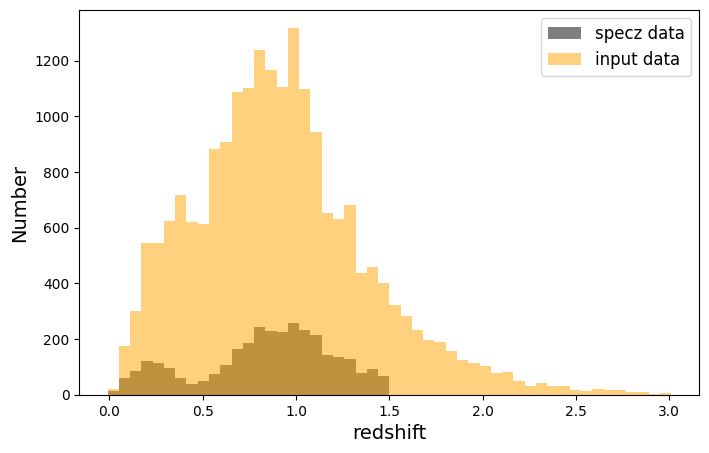

In [4]:
plt.figure(figsize=(8,5))
zbins = np.linspace(-.01, 3.01, 51)
plt.hist(ref_data()['redshift'], bins=zbins, alpha=0.5, color='k', label="specz data");
plt.hist(test_data()['redshift'], bins=zbins, alpha=0.5, color='orange', label="input data");
plt.legend(loc='upper right', fontsize=12)
plt.xlabel("redshift", fontsize=14)
plt.ylabel("Number", fontsize=14);

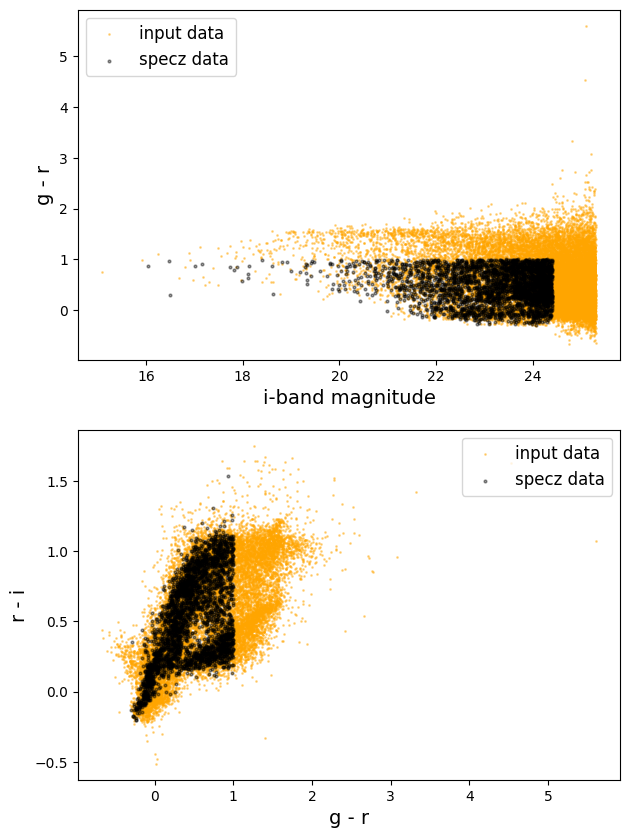

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(7,10))
axs[0].scatter(test_data()['mag_i_lsst'], test_data()['mag_g_lsst'] - test_data()['mag_r_lsst'], 
            s=1, label='input data', alpha=0.4, color='orange')
axs[0].scatter(ref_data()['mag_i_lsst'], ref_data()['mag_g_lsst'] - ref_data()['mag_r_lsst'], 
            s=4, label='specz data', alpha=0.4, color='k')
axs[0].legend(loc='upper left', fontsize=12)
axs[0].set_xlabel("i-band magnitude", fontsize=14)
axs[0].set_ylabel("g - r", fontsize=14);


axs[1].scatter(test_data()['mag_g_lsst'] - test_data()['mag_r_lsst'], 
               test_data()['mag_r_lsst'] - test_data()['mag_i_lsst'], 
            s=1, label='input data', alpha=0.4, color='orange')
axs[1].scatter(ref_data()['mag_g_lsst'] - ref_data()['mag_r_lsst'],
               ref_data()['mag_r_lsst'] - ref_data()['mag_i_lsst'], 
            s=4, label='specz data', alpha=0.4, color='k')
axs[1].legend(loc='upper right', fontsize=12)
axs[1].set_xlabel("g - r", fontsize=14)
axs[1].set_ylabel("r - i", fontsize=14);


We can see that, given our cuts, our "specz" data is no longer representaive of the input sample.  Now, let's set up our degrader to try to select a subset of galaxies that matches the number and distribution of the specz sample.  We'll start by setting up the `SOMSpecSelector` stage.  As input, the stage takes in multiple config parameters, these are:

- noncolor_cols: a list of column names in the files that will be used directly in training the SOM

- color_cols: a list of column names in the files, these will be taken in order and differenced to make, e.g. colors.  So, if you want to include u-g, g-r, and r-i as inputs to the SOM, you would specify ['u', 'g', 'r', 'i'] as the `color_cols` values, and these will be differenced before inclusion in the SOM.

 - nondetect_val: if this value is present in either `noncolor_cols` or `color_cols` columns as a value, it will be replaced with the corresponding "nondetection value" in `noncolor_nondet` and`color_nondet` respectively.
                          
- noncolor_nondet: the list of nondetect values that a non-detection in `noncolor_cols` should be replaced with

- color_nondet: the list of nondetect values that a non-detection in `color_cols` should be replaced with
                          
- som_size: a tuple,  e.g. (32, 32), that specifies the shape of the SOM.  (32, 32) is the default.


Let's set up our inputs.  As an example, let's train our SOM using i-band magnitude, redshift, and the colors u-g, g-r, r-i, i-z, and z-y.  To do this, we will specify `noncolor_cols` of 'mag_i_lsst' and 'redshift', and color_cols with all six magnitudes.  The code will difference the six magnitudes, producing the desired five colors.  Thus, our SOM inputs will be trained on six inputs: `mag_i_lsst`, `u-g`, `g-r`, `r-i`, `i-z`, and `z-y`.  Given that our mock data has true redshifts, we could also include `redshift` as an explicit feature, which would lead to even better results; however, for this demo we will test without redshift included as a test of how well the method does in recovering the redshift distribution with only the implicit color -> redshift relation information included.

We also need to specify the magnitude and color limits, we'll use the 1 sigma i-band 10 year limit for i-band and just put -1.0 for redshift.  For colors we'll just put 0.0 for all colors.

In [6]:
bands = ['u', 'g', 'r', 'i', 'z', 'y']
noncol_cols = ['mag_i_lsst']
col_cols = []
for band in bands:
    col_cols.append(f"mag_{band}_lsst")

noncol_nondet = [28.62, -1.0]
col_nondet = np.zeros(5, dtype=float)

som_dict = dict(color_cols=col_cols,
                noncolor_cols=noncol_cols,
                nondetect_val=99.0,
                noncolor_nondet=noncol_nondet,
                color_nondet=col_nondet)

In [7]:
som_degrade = SOMSpecSelector.make_stage(
    name="som_degrader",
    output="specz_mock_sample.pq",
    **som_dict,
)

In [8]:
trimdf = som_degrade(input_data=test_data, spec_data=ref_data)

Inserting handle into data store.  input: None, som_degrader
Inserting handle into data store.  spec_data: None, som_degrader
Inserting handle into data store.  output_som_degrader: inprogress_specz_mock_sample.pq, som_degrader


let's plot the redshift histogram and mag vs color plot to see how well our selection matches the reference set:

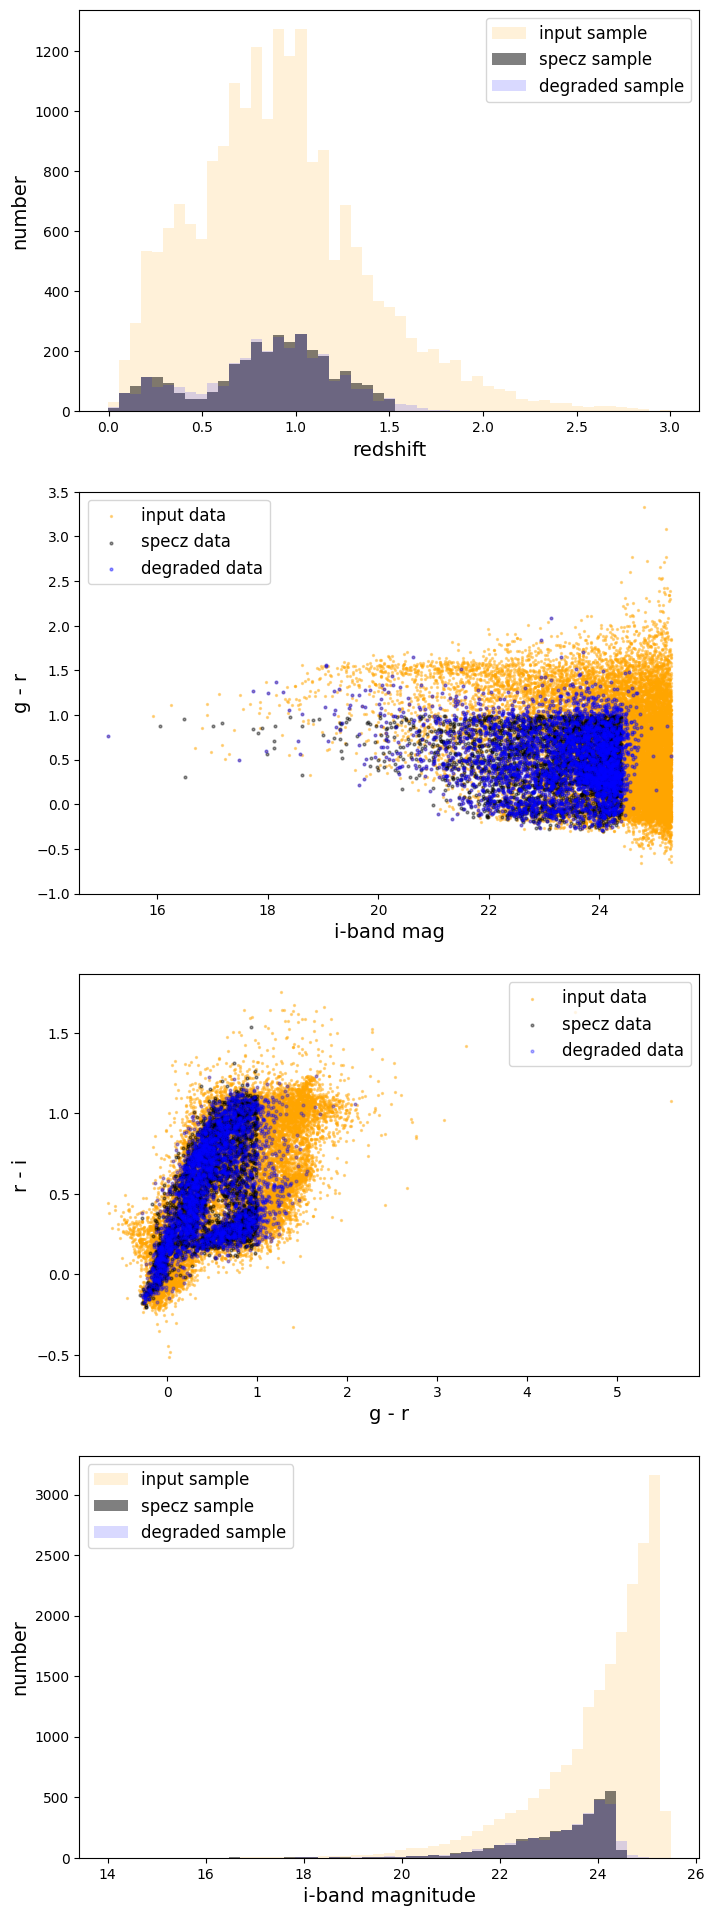

In [9]:
fig, axs = plt.subplots(4,1, figsize=(8,24))
xbins = np.linspace(-.005, 3.005,52)
magbins = np.linspace(14, 25.5, 52)
axs[0].hist(test_data()['redshift'], bins=xbins, alpha=0.15, color='orange', label='input sample');
axs[0].hist(ref_data()['redshift'], bins=xbins, alpha=0.5, color='k', label='specz sample');
axs[0].hist(trimdf()['redshift'], bins=xbins, alpha=0.15, color='b', label='degraded sample')
axs[0].set_xlabel('redshift', fontsize=14)
axs[0].legend(loc='upper right', fontsize=12)
axs[0].set_ylabel('number', fontsize=14);

axs[1].scatter(test_data()['mag_i_lsst'], test_data()['mag_g_lsst'] - test_data()['mag_r_lsst'], 
            s=2, label='input data', alpha=0.4, color='orange')
axs[1].scatter(ref_data()['mag_i_lsst'], ref_data()['mag_g_lsst'] - ref_data()['mag_r_lsst'], 
            s=4, label='specz data', alpha=0.4, color='k')
axs[1].scatter(trimdf()['mag_i_lsst'], trimdf()['mag_g_lsst'] - trimdf()['mag_r_lsst'], 
            s=4, label='degraded data', alpha=0.4, color='b')
axs[1].legend(loc='upper left', fontsize=12)
axs[1].set_ylim(-1,3.5);
axs[1].set_xlabel("i-band mag", fontsize=14)
axs[1].set_ylabel("g - r", fontsize=14)

axs[2].scatter(test_data()['mag_g_lsst'] - test_data()['mag_r_lsst'], 
               test_data()['mag_r_lsst'] - test_data()['mag_i_lsst'], 
            s=2, label='input data', alpha=0.4, color='orange')
axs[2].scatter(ref_data()['mag_g_lsst'] - ref_data()['mag_r_lsst'],
               ref_data()['mag_r_lsst'] - ref_data()['mag_i_lsst'], 
            s=4, label='specz data', alpha=0.4, color='k')
axs[2].scatter(trimdf()['mag_g_lsst'] - trimdf()['mag_r_lsst'],
               trimdf()['mag_r_lsst'] - trimdf()['mag_i_lsst'], 
            s=4, label='degraded data', alpha=0.3, color='b')
axs[2].legend(loc='upper right', fontsize=12)
axs[2].set_xlabel("g - r", fontsize=14)
axs[2].set_ylabel("r - i", fontsize=14)

axs[3].hist(test_data()['mag_i_lsst'], bins=magbins, alpha=0.15, color='orange', label='input sample');
axs[3].hist(ref_data()['mag_i_lsst'], bins=magbins, alpha=0.5, color='k', label='specz sample');
axs[3].hist(trimdf()['mag_i_lsst'], bins=magbins, alpha=0.15, color='b', label='degraded sample')
axs[3].set_xlabel('i-band magnitude', fontsize=14)
axs[3].legend(loc='upper left', fontsize=12)
axs[3].set_ylabel('number', fontsize=14);


The redshift distribution of our degraded sample matches very well with the reference data, the magnitude vs color distribution is not as clean; however, this is very likely due to the small number of objects used to train the SOM, and performance and matchup should improve with larger samples.  Below we will download a slightly larger data samples, and we can (optionally) test how well the results agree when more data is available.  


**Note:**
The files are rather large, so you will need to uncomment the lines below in order to download the files and have the second half of this notebook run.  Let's grab some data from the Roman-DESC sims, we'll grab a tar file with two files, one with 37,500 galaxies, and one with 75,000 galaxies:

## Uncomment the lines in the cell below and execute to download the data needed for the rest of the notebook!

In [11]:
training_file = "./romandesc_specdeep.tar"

#UNCOMMENT THESE LINES TO GRAB THE LARGER DATA FILES!

if not os.path.exists(training_file):
  os.system('curl -O https://portal.nersc.gov/cfs/lsst/PZ/romandesc_specdeep.tar')
!tar -xvf romandesc_specdeep.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32.6M  100 32.6M    0     0  10.3M      0  0:00:03  0:00:03 --:--:-- 10.3M


romandesc_spec_data_37k.hdf5
romandesc_deep_data_75k.hdf5


We will read in the two files, make similar cuts to the mock "spec" file as we did in the example above, and then add the files to the datastore

In [ ]:
rdspecfile = "./romandesc_spec_data_37k.hdf5"
rdtestfile = "./romandesc_deep_data_75k.hdf5"

rdtest = tables_io.read(rdtestfile)
rdtestpq = tables_io.convert(rdtest, tables_io.types.PD_DATAFRAME)
big_test_data = rdtestpq

rdspec = tables_io.read(rdspecfile)
rdspecpq = tables_io.convert(rdspec, tables_io.types.PD_DATAFRAME)

mask = np.logical_and(rdspecpq['redshift'] < 1.5,
                      np.logical_and(rdspecpq['i'] < 24.4, 
                                     rdspecpq['g'] - rdspecpq['r'] < 1.0))
rdspecpqcut = rdspecpq[mask]
big_spec_data = rdspecpqcut

Let's take a look at the columns available, this file should contain both the magnitudes and colors for the Roman-DESC sims:

In [20]:
big_spec_data.head()

,F,F_err,H,HF,HF_err,H_err,J,JH,JH_err,J_err,...,ug,ug_err,y,yJ,yJ_err,y_err,z,z_err,zy,zy_err
0,22.668509,0.009416,22.670394,0.001886,0.011532,0.006658,22.863637,0.193243,0.009721,0.007083,...,0.052752,0.054803,23.055371,0.191734,0.041568,0.040960,23.133485,0.019674,0.078114,0.045440
4,23.381875,0.016141,23.610780,0.228905,0.019860,0.011570,23.635874,0.025094,0.016213,0.011358,...,-0.053434,0.084056,23.729567,0.093693,0.075335,0.074473,23.856372,0.036887,0.126805,0.083108
5,23.168731,0.013580,23.407798,0.239067,0.016865,0.010000,23.441274,0.033476,0.014063,0.009887,...,0.050993,0.070531,23.593863,0.152589,0.066782,0.066046,23.670904,0.031320,0.077041,0.073096
6,23.580251,0.019068,23.697910,0.117659,0.022723,0.012359,23.683574,-0.014335,0.017066,0.011769,...,0.536931,0.124959,23.838711,0.155137,0.082847,0.082007,23.975645,0.040996,0.136934,0.091683
11,23.560218,0.018746,23.498393,-0.061825,0.021563,0.010657,23.626236,0.127843,0.015516,0.011277,...,0.305268,0.146536,23.642759,0.016523,0.069884,0.068969,24.036394,0.043264,0.393635,0.081415


As in the first example, we will just use one magnitude, `i`, and the five colors to build the SOM.  Because the colors are already present we can just add them directly to the non-color columns. Let's set things up appropriately:

In [13]:
noncol_cols = ['i', 'ug', 'gr', 'ri', 'iz', 'zy']
col_cols = []

noncol_nondet = [28.62, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
col_nondet = []

som_dict = dict(color_cols=col_cols,
                noncolor_cols=noncol_cols,
                nondetect_val=99.0,
                noncolor_nondet=noncol_nondet,
                color_nondet=col_nondet)

**Note:** as mentioned earlier in this demo, the `SOMSpecSelector` stage expects the reference/spectroscopic data file to be labeled as "spec_data" in the DataStore.  As we already loaded the previous example data with that name, we'll need to tell this second copy of the `SOMSpecSelector` stage that we will be using a dataset with a different label.  We do this by setting the new label in a dictionary fed in as `aliases` to the stage.  We added the new reference/specz file with the label "big_spec", so we can simply add `aliases=dict(spec_data="big_spec")` to let the stage know which file to use as the reference/spec data.

In [15]:
# note that 
roman_som_degrade = SOMSpecSelector.make_stage(name="roman_som_degrader", 
                                               output="roman_specz_mock_sample.pq", 
                                               aliases=dict(spec_data="big_spec"),
                                               **som_dict)

In [16]:
roman_trim = roman_som_degrade(input_data=big_test_data, spec_data=big_spec_data)

Inserting handle into data store.  input: None, roman_som_degrader
Inserting handle into data store.  big_spec: None, roman_som_degrader


/home/jscora/code/desc-rail/rail_som/src/rail/creation/degraders/specz_som.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[mask, val] = np.float32(lim)


Inserting handle into data store.  output_roman_som_degrader: inprogress_roman_specz_mock_sample.pq, roman_som_degrader


Let's make the same plots as above:

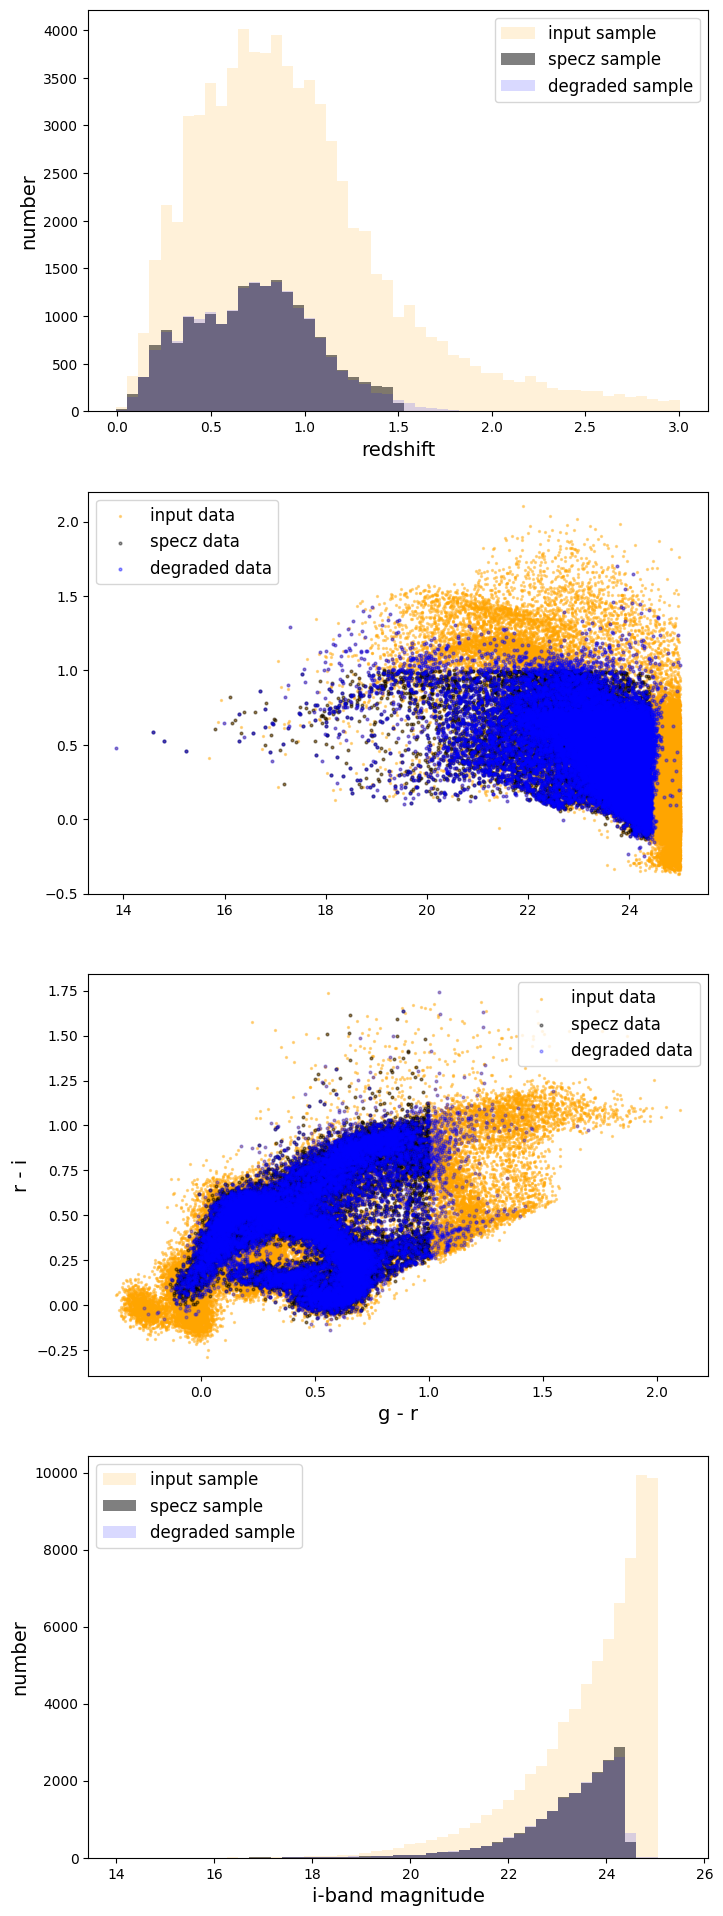

In [19]:
fig, axs = plt.subplots(4,1, figsize=(8,24))
xbins = np.linspace(-.005, 3.005,52)
magbins = np.linspace(14, 25.5, 52)
axs[0].hist(big_test_data['redshift'], bins=xbins, alpha=0.15, color='orange', label='input sample');
axs[0].hist(big_spec_data['redshift'], bins=xbins, alpha=0.5, color='k', label='specz sample');
axs[0].hist(roman_trim()['redshift'], bins=xbins, alpha=0.15, color='b', label='degraded sample')
axs[0].set_xlabel('redshift', fontsize=14)
axs[0].legend(loc='upper right', fontsize=12)
axs[0].set_ylabel('number', fontsize=14);

axs[1].scatter(big_test_data['i'], big_test_data['gr'], 
            s=2, label='input data', alpha=0.4, color='orange')
axs[1].scatter(big_spec_data['i'], big_spec_data['gr'], 
            s=4, label='specz data', alpha=0.4, color='k')
axs[1].scatter(roman_trim()['i'], roman_trim()['gr'], 
            s=4, label='degraded data', alpha=0.4, color='b')
axs[1].legend(loc='upper left', fontsize=12)
axs[1].set_ylim(-.5,2.2);

axs[2].scatter(big_test_data['gr'], 
               big_test_data['ri'], 
               s=2, label='input data', alpha=0.4, color='orange')
axs[2].scatter(big_spec_data['gr'],
               big_spec_data['ri'],
               s=4, label='specz data', alpha=0.4, color='k')
axs[2].scatter(roman_trim()['gr'],
               roman_trim()['ri'],
               s=4, label='degraded data', alpha=0.3, color='b')
axs[2].legend(loc='upper right', fontsize=12)
axs[2].set_xlabel("g - r", fontsize=14)
axs[2].set_ylabel("r - i", fontsize=14)

axs[3].hist(big_test_data['i'], bins=magbins, alpha=0.15, color='orange', label='input sample');
axs[3].hist(big_spec_data['i'], bins=magbins, alpha=0.5, color='k', label='specz sample');
axs[3].hist(roman_trim()['i'], bins=magbins, alpha=0.15, color='b', label='degraded sample')
axs[3].set_xlabel('i-band magnitude', fontsize=14)
axs[3].legend(loc='upper left', fontsize=12)
axs[3].set_ylabel('number', fontsize=14);

We again see good agreement on the redshift and i-band magnitude distributions, and good but not perfect agreement on magnitude-color and color-color distributions.  So, it appears that our mock specz selection algorithm is working as expected.